In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import re
import dlib
import traceback
CLASSES = {3:'with mask',2:'without mask',1:'Mask below the nose',0:'mask below the chin'}

In [11]:
haarFace_path = r"Models\HaarCascade\haarcascade_frontalface_default.xml"
haarEye_path = r"Models\HaarCascade\haarcascade_eye.xml"
haarMouth_path = r"Models\HaarCascade\Mouth.xml"
cascadeFace_detector = cv2.CascadeClassifier(haarFace_path)
cascadeEye_detector = cv2.CascadeClassifier(haarEye_path)
cascadeMouth_detect = cv2.CascadeClassifier(haarMouth_path)

In [12]:
landmark_predictor = dlib.shape_predictor("Models/DLIB/shape_predictor_68_face_landmarks.dat")
dlib_detector = dlib.get_frontal_face_detector()

In [13]:
mask_model = tf.keras.models.load_model('Models/mask_detection/model.h5')


In [14]:
mask_model.load_weights('Models/mask_detection/mask_weights.h5')

In [ ]:
mask_model.summary()

In [74]:
mask_model = tf.keras.models.load_model('Models/maskModel_v3.h5')

In [15]:
def predictMask(img):
    """rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # !!! openCV uses BGR !!! need to switch to RGB !!!"""
    #adjusted = cv2.convertScaleAbs(img, alpha=1.4, beta=10)
    # Play with the saturation and hue for better results.
    color_options = [[1.5,1.8],[1,1]]
    satur_factor = color_options[1][0]
    hue_factor = color_options[1][1]
    IMG_DIM = (300,300)
    resized = cv2.resize(img,IMG_DIM,interpolation = cv2.INTER_AREA)
#     hsvImg = cv2.cvtColor(resized,cv2.COLOR_BGR2HSV)
# # dealing with colors changing the detection performance (mainly the pink masks problem and the brightness) :
#     # multiple by a factor to change the saturation
#     hsvImg[...,1] = hsvImg[...,1]*satur_factor

#     # multiple by a factor of less than 1 to reduce the brightness 
#     #hsvImg[...,2] = hsvImg[...,2]*0.95 # - creates disturbance in the image

#     # multiple by a factor to change the hue
#     hsvImg[...,0] = hsvImg[...,0]*hue_factor

#     img_array = cv2.cvtColor(hsvImg,cv2.COLOR_HSV2BGR)
#     #cv2.imshow("enhanced",img_array)
#     #cv2.imshow("re",resized)
#     img_array = np.asarray(img_array)
#     #img_array = np.stack((img_array,)*3, axis=-1)
    img_array = cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
    # mean1, std1 = img_array.mean(), img_array.std()
    # img_array = (img_array - mean1) / (std1)
    # plt.imshow(img_array)
    img_array = img_array / 255
    img_array = np.expand_dims(img_array,axis=0)
    #img_array = img_array/255.0
    prediction = mask_model.predict(img_array)
    #print(prediction)
    index = np.argmax(prediction)
    #print("Prediction",CLASSES[index], prediction[0][index])
    return index

# index == 0 : with mask, index == 1 without mask.

In [22]:
import ctypes  # An included library with Python install.   

def isMouthVisible(face):
    mouths = cascadeMouth_detect.detectMultiScale(face, 1.3, 3)
    if len(mouths):
        return True
    return False

### TODO: 1) add dynamic brightness(which i already wrote) to the main code, 2) add the arcface functionality after mask detection, 3) clean and organize the code in .py , 4) debug and clean bugs 

ipykernel_launcher:29: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.


['PersonaEmbeddings']
0.038865293177188454
Lior Shamanov
0.09195995362241338
Lior Shamanov
0.11707218849821499
Lior Shamanov
0.10602268770129697
Lior Shamanov
0.08792197363866328
Lior Shamanov
0.09185657900337585
Lior Shamanov
0.09790492125431005
Lior Shamanov
0.0907544110053593
Lior Shamanov
0.04449579531894976
Lior Shamanov
0.11494143004119306
Lior Shamanov
0.11949012800565617
Lior Shamanov
0.12971926583980975
Lior Shamanov
0.08982730858902821
Lior Shamanov


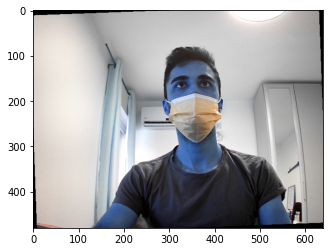

In [42]:
cap = cv2.VideoCapture(0)
steady_eyes = False
steady_face = False
message_string = None
e_startTime = 0
f_startTime = 0
eyes_detectedTime = 0
face_detectedTime = 0
rec_posColor = (0,255,0)
rec_negColor = (255,0,0)
REC_COLOR = rec_negColor
mask_msg = CLASSES[2]
(xf,yf,wf,hf) = (0,0,0,0)
x_face,y_face = 0,0 # face roi top left position
landmark=[]
detected_centroids = []
crop_count = 0
identified = False
#minimum_brightness = 0.6
try:
    collection = get_dbCollection()
    while True:
        #count = 0
        ret, img = cap.read()
        #copy_img = img.copy()
        # check the brightness
        
        #adjusted = cv2.convertScaleAbs(img, alpha=1.1, beta=35)
        dyn_img = dynamicBrightness(img,minimum_brightness=0.64)
        copy_img = dyn_img.copy()
        #adjusted = img
        # cv2.putText(img, message_string, (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        faces = cascadeFace_detector.detectMultiScale(dyn_img, 1.12, 6,minSize = (85,85))
        eyes = cascadeEye_detector.detectMultiScale(dyn_img, 1.2, 4) # 1.3 - image scale reduction, 5 - how many neighbors for each prediction, higher value is less detection yet higher quality.
        b_face = (True if len(faces) else False)
        for (xf,yf,wf,hf) in faces:
            # if steady_face == False:
            if face_detectedTime == 0:
                f_startTime = time.perf_counter()
                # steady_face = True
            cv2.rectangle(copy_img, (xf,yf), (xf+wf+1, yf+hf+1), REC_COLOR, 2)
            face = dyn_img[yf : yf + hf, xf: xf + wf]
            x_face, y_face = xf , yf
            x_centroid = xf + wf/2
            y_centroid = yf + hf/2
            #count+=1
        # if len(faces) == 0:
        #     # steady_face = False
        #     f_startTime = 0

    # if we got 2 eyes, draw them and check for steadiness
        if len(eyes) == 2:
            # if steady_eyes == False:
            if eyes_detectedTime == 0:
                e_startTime = time.perf_counter()
                # steady_eyes = True
            # for (xe,ye,we,he) in eyes:
            for count,(eye_x, eye_y, eye_w, eye_h) in enumerate(eyes):
                if count == 0:
                    eye_1 = (eye_x, eye_y, eye_w, eye_h)
                else:
                    eye_2 = (eye_x, eye_y, eye_w, eye_h)

                cv2.rectangle(copy_img,(eye_x,eye_y), (eye_x+eye_w, eye_y+eye_h),REC_COLOR,1)


            # check if the detected eyes are positioned inside our face's frame (the coordinates are contained in the face range)
            eyes_in_range =  (eye_x + eye_w,eye_y + eye_h,eye_w ,eye_h) < (xf+wf,yf+hf,wf,hf) and (eye_x, eye_y) > (xf, yf)

            if e_startTime > 0 and f_startTime > 0 and b_face:
                # if eyes and face are detected for atleast 1 second (meaning detection is steady), and the eyes are in the face's range, proceed to estimate landmarks.      
                eyes_detectedTime += time.perf_counter() - e_startTime
                face_detectedTime += time.perf_counter() - f_startTime
                #print(eyes_detectedTime, face_detectedTime, e_startTime, f_startTime)
                if eyes_detectedTime >= 1 and face_detectedTime >= 1 and eyes_in_range:
                    #if(len(faces) > 0):
                    b_mouth = isMouthVisible(face)
                    detected_centroids.append([x_centroid,y_centroid])
                    cv2.putText(copy_img, mask_msg, (xf,yf), cv2.FONT_HERSHEY_SIMPLEX, 0.5, REC_COLOR,2)
                    #get estimation of face landmarks
                    if(not b_mouth):
                        prediction = predictMask(face)
                        #print(prediction)
                        if prediction == 3:
                            REC_COLOR = rec_posColor
                            aligned_face, is_aligned = alignFace(dyn_img,eye_1,eye_2,cascadeFace_detector)
                            if is_aligned :
                                cv2.imshow('aligned',aligned_face)
                                face = aligned_face
                            # cropped_face = get_cropped_face(face,landmark_predictor)
                            landmark = landmark_predictor(face,dlib.rectangle(0,0,face.shape[0],face.shape[1])) # face frame and it's dlib frame
                            if(landmark.num_parts > 0):
                            # use the middle point of the nose (dynamically changes in accordance to the mask position on the nose)
                            # point 29 was found to be the ideal point for cropping the part outside the mask
                                last_nose_pt = landmark.part(29)
                                cropped_face = face[ 0 : last_nose_pt.y +1, 0 : face.shape[1]]
                                
                                identified = True
                                cv2.circle(copy_img,(last_nose_pt.x + x_face, last_nose_pt.y + y_face),6,(0,0,255),-1)
                                cv2.circle(copy_img,(landmark.part(20).x + x_face,landmark.part(20).y +y_face ),6,(0,0,255),-1)
                                cv2.putText(copy_img, "Identified as: Lior", (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, rec_posColor,2)
                                # steady_eyes = False
                                # steady_face = False
                                eyes_detectedTime = 0
                                face_detectedTime = 0
                                f_startTime = 0
                                e_startTime = 0
                                cv2.imshow('cropped_face',cropped_face)
                                mbox = ctypes.windll.user32.MessageBoxW(0, "Your text", "Your title", 1)
                                #print(mbox)
                                if mbox == 1:
                                    embedding = predict_embedding(m_FaceArc,cropped_face)
                                    persona = recognize_persona(collection,embedding)
                                    print(persona)
                        else:
                            REC_COLOR = rec_negColor
                        mask_msg = CLASSES[prediction]
                    else:
                        REC_COLOR = rec_negColor
                        mask_msg = CLASSES[2]
        # else:
        #     # steady_eyes = False
        #     e_startTime = 0
            # face_detectedTime = time.time() - face_detectedTime
            # if steady_face and face_detectedTime >= 0.5:
            #     message_string = "Make sure your eyes are visible"
            # else:
            #     message_string = None

        action = cv2.waitKey(1) & 0xff
        # cv2.imwrite('cropped_face1.png',cropped_face)
        # cv2.imwrite('full_face.png',face)
        if action == 27: # escape button
            cv2.imwrite(f'full_face_no{crop_count}.png',face)
            cv2.imwrite(f'cropped_face{crop_count}.png',cropped_face)
            crop_count+=1
            break
        elif action == 32:
            break
        #elif action == ord('r'):
        cv2.imshow('img',copy_img)

except Exception as e: 
    traceback.print_exc()
    cap.release()
    cv2.destroyAllWindows()
    
cap.release()
cv2.destroyAllWindows()

### Code Functions

In [17]:
import numpy as np
from numpy.linalg import norm

def dynamicBrightness(img,minimum_brightness = 0.55):
    cols, rows = img.shape[0],img.shape[1]
    brightness = np.average(norm(img, axis=2)) / np.sqrt(3) / 255
    ratio = brightness / minimum_brightness
    #cv2.putText(img, f"brightness:{brightness}", (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)

    #print(ratio)
    if ratio >= 1:
        return img

# Otherwise, adjust brightness to get the target brightness
    return cv2.convertScaleAbs(img, alpha = 1 / ratio, beta = 0)

In [35]:
embedding[0]

(512,)

In [43]:
# A check of the embedding difference between rotated and original
from scipy import spatial
modelDir = 'Models/ArcFace/TT_mobilenet_pointwise_distill_128_arc_emb512_dr04_wd5e4_bs400_r100_ms1m_fp16_basic_agedb_30_epoch_45_0.972833.h5'
m_FaceArc = tf.keras.models.load_model(modelDir,compile=False)

INPUT_SIZE = (112,112)
from pymongo import MongoClient
# pprint library is used to make the output look more pretty
from pprint import pprint

def get_crop_face(face,landmark_predictor):
    landmark = landmark_predictor(face,dlib.rectangle(0,0,face.shape[0],face.shape[1])) # face frame and it's dlib frame
    if(landmark.num_parts > 0):
    # use the middle point of the nose (dynamically changes in accordance to the mask position on the nose)
    # point 29 was found to be the ideal point for cropping the part outside the mask
        last_nose_pt = landmark.part(29)
        cropped_face = face[ 0 : last_nose_pt.y +1, 0 : face.shape[1] ]

    return cropped_face

def predict_embedding(model,img):
    im_input = cv2.resize(img,INPUT_SIZE)
    embedding = model.predict(np.expand_dims(im_input.astype(float),axis=0))
    return embedding

def get_dbCollection():
    client = xxx
    db = client["MFR_DB"]
    print(db.collection_names())
    collection = db["PersonaEmbeddings"]
    return collection

def insert_persona(collection,embedding,name):
    person_entry = {"name":name,"embedding":list(embedding[0].astype(float))}
    collection.insert_one(person_entry)

def recognize_persona(collection,embedding):
    persona = None
    cos_thresh = 0.35
    euc_thresh = 4
    persona_data = collection.find({})
    iden_list = [[],[],[]]
    for identity in persona_data:
        data_embed = identity["embedding"]
        cos_dist = spatial.distance.cosine(data_embed,embedding)
        euc_dist = np.sqrt(np.sum((data_embed - embedding)**2))
        iden_list[0].append(euc_dist)
        iden_list[1].append(cos_dist)
        iden_list[2].append(identity["name"])

    if not any(iden_list):
        # list is empty, no entries in db
        NAME=str(input("enter your full name: "))
        insert_persona(collection,embedding,NAME)
    else:
        euc_i = np.argmin(iden_list[0])
        cos_i = np.argmin(iden_list[1])
        if cos_i == euc_i and cos_i < cos_thresh:
        #print(iden_list[0][euc_i],iden_list[1][cos_i])
            print(iden_list[1][cos_i])
            persona = iden_list[2][cos_i]
    return persona
    # if persona is None - try again -  2 times overall, after 2 times of no prediction -  add new image with name to the database
        

In [20]:
# i only need the part after the face detection, that i will do in another function
import math
from PIL import Image
import PIL

def euclidean_distance(a, b):
    x1 = a[0]; y1 = a[1]
    x2 = b[0]; y2 = b[1]
    return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

def alignFace(img,eye_1,eye_2,cascadeFace_detector):
    try:
        img_raw = img.copy()

        if eye_1[0] <= eye_2[0]:
            left_eye = eye_1
            right_eye = eye_2
        else:
            right_eye = eye_1
            left_eye = eye_2

        left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
        left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]
        
        right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
        right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]
        
        if left_eye_y > right_eye_y:
            point_3rd = (right_eye_x, left_eye_y)
            direction = -1 #rotate in clock direction
        else:
            point_3rd = (left_eye_x, right_eye_y)
            direction = 1 #rotate inverse clock direction

        # you can directly use this line to convert the BGR image to RGB: [:,:,::-1]
        a = euclidean_distance(left_eye_center, point_3rd)
        b = euclidean_distance(right_eye_center, left_eye_center)
        c = euclidean_distance(right_eye_center, point_3rd)
        cos_a = (b*b + c*c - a*a)/(2*b*c)
        
        angle = np.arccos(cos_a)
        
        angle = (angle * 180) / math.pi
        # because we need the angle on the left eye (the small angle), we need to subtract 90 incase the direction is -1 (since in the case we calculate the bigger degree)
        if direction == -1:
            angle = 90 - angle

        rot_img = Image.fromarray(img_raw)
        '''
        Using resampling filter in the rotation : PIL.Image.BILINEAR, since during rotation,
        the pixels get deformed/distorted, so we apply the resampling filter to sample pixels,
        in a way that will fit the change of pixels in rotation.
        '''
        rot_img = np.array(rot_img.rotate(direction * angle,PIL.Image.BILINEAR))
        #img_gray = cv2.cvtColor(rot_img, cv2.COLOR_BGR2GRAY)
        r_faces = cascadeFace_detector.detectMultiScale(rot_img, 1.3, 5,minSize = (80,80))
        #print(r_faces)
        if(not len(r_faces)):
            plt.imshow(rot_img)
            #print(left_eye,right_eye,angle)
        face_x, face_y, face_w, face_h = r_faces[0]
        rot_face = rot_img[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]
        return rot_face,True
    except:
        return 0,False

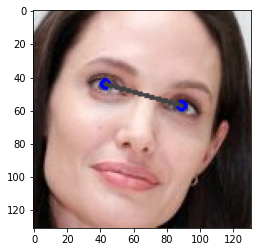

In [180]:
color = [0,125,0]
img = cv2.imread("Misc/angelina.jpg")
plt.imshow(img)
img_raw = img.copy()
faces = cascadeFace_detector.detectMultiScale(img, 1.3, 5)
face_x, face_y, face_w, face_h = faces[0]
img = img[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
##
eyes = cascadeEye_detector.detectMultiScale(img_gray)

# index = 0
# for (eye_x, eye_y, eye_w, eye_h) in eyes:
#     if index == 0:
#         eye_1 = (eye_x, eye_y, eye_w, eye_h)
#     elif index == 1:
#         eye_2 = (eye_x, eye_y, eye_w, eye_h)

#     cv2.rectangle(img,(eye_x, eye_y),(eye_x+eye_w, eye_y+eye_h), color, 2)
#     index = index + 1
for count,(eye_x, eye_y, eye_w, eye_h) in enumerate(eyes):
    if count == 0:
        eye_1 = (eye_x, eye_y, eye_w, eye_h)
    else:
        eye_2 = (eye_x, eye_y, eye_w, eye_h)

if eye_1[0] < eye_2[0]:
    left_eye = eye_1
    right_eye = eye_2
else:
    right_eye = eye_1
    left_eye = eye_2

left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]
 
right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]
 
cv2.circle(img, left_eye_center, 2, (255, 0, 0) , 2)
cv2.circle(img, right_eye_center, 2, (255, 0, 0) , 2)
cv2.line(img,right_eye_center, left_eye_center,(67,67,67),2) 
# you can directly use this line to convert the BGR image to RGB: [:,:,::-1]
plt.imshow(img[:,:,::-1])

rotate to inverse clock direction


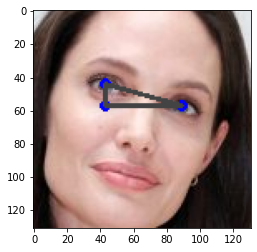

In [181]:
if left_eye_y > right_eye_y:
   point_3rd = (right_eye_x, left_eye_y)
   direction = -1 #rotate in clock direction
   print("rotate to clock direction")
else:
   point_3rd = (left_eye_x, right_eye_y)
   direction = 1 #rotate inverse clock direction
   print("rotate to inverse clock direction")
 
cv2.circle(img, point_3rd, 2, (255, 0, 0) , 2)
 
cv2.line(img,right_eye_center, left_eye_center,(67,67,67),2)
cv2.line(img,left_eye_center, point_3rd,(67,67,67),2)
cv2.line(img,right_eye_center, point_3rd,(67,67,67),2)
plt.imshow(img[:,:,::-1])

In [182]:
# Calculating the angle of rotation (in our case - the angle on the right) using cosine rule, with the triangle we got
import math
def euclidean_distance(a, b):
    x1 = a[0]; y1 = a[1]
    x2 = b[0]; y2 = b[1]
    return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))
a = euclidean_distance(left_eye_center, point_3rd)
b = euclidean_distance(right_eye_center, left_eye_center)
c = euclidean_distance(right_eye_center, point_3rd)
cos_a = (b*b + c*c - a*a)/(2*b*c)
print("cos(a) = ", cos_a)
 
angle = np.arccos(cos_a)
print("angle: ", angle," in radian")
 
angle = (angle * 180) / math.pi
print("angle: ", angle," in degree")
# because we need the angle on the left eye (the small angle), we need to subtract 90 incase the direction is -1 (since in the case we calculate the bigger degree)
if direction == -1:
   angle = 90 - angle

cos(a) =  0.9623094031071991
angle:  0.2754261036960354  in radian
angle:  15.78075330951539  in degree


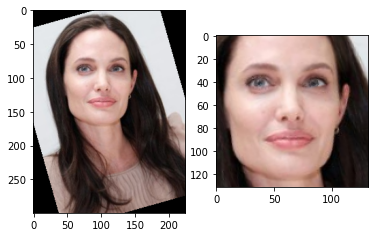

In [200]:
# Rotating the image:
from PIL import Image
import PIL
from scipy.ndimage import rotate
rot_img = Image.fromarray(img_raw)
'''
Using resampling filter in the rotation : PIL.Image.BILINEAR, since during rotation,
the pixels get deformed/distorted, so we apply the resampling filter to sample pixels,
in a way that will fit the change of pixels in rotation.
'''
x = [[face_x,face_y],[face_x+face_w,face_y+face_h]]
px, py = rotate_p((0,0),x[0],math.radians(angle))
pxh, pyh = rotate_p((0,0),x[1],math.radians(angle))
rot_img = np.array(rot_img.rotate(direction * angle,PIL.Image.BILINEAR))
f, ax = plt.subplots(1,2)
ax[0].imshow(rot_img[:,:,::-1])
#face_y,face_yh,face_x,face_xw= x[0]|
rot_face = rot_img[py-1 : py+face_h, px-1:px+face_w]
ax[1].imshow(rot_face[:,:,::-1])

In [192]:
print(px,py,pxh,pyh,int(face_y),int(face_yh), int(face_x),int(face_xw))

39 46 129 208 34 165 50 181


In [185]:
import math

def rotate_p(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return abs(round(qx)),abs(round(qy))

In [47]:
i = cv2.resize(img_raw[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)],(112,112))
r = cv2.resize(rot_img[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)],(112,112))
i.shape
embeddin1 = m_FaceArc.predict(np.expand_dims(i.astype(float),axis=0))
embeddin2 = m_FaceArc.predict(np.expand_dims(r.astype(float),axis=0))


In [51]:
cos_dist = spatial.distance.cosine(embeddin2,embeddin1)
print(cos_dist)
# its not zero, meaning theres an effect of the face orientation and position (even though its the same image)

0.06682133674621582
